<a href="https://colab.research.google.com/github/ksushrut/CoinClassifier/blob/main/Adv_CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coin Classification

## Guidelines
1) Please import packages in the import section only.

2) Use sensible variable names. If possible try to describe the use of the variables in the variable description section.

3) Github commits and branches?

4) set device to gpu. No cpu!


# PIP Install statements

# Import packages here

In [41]:
# write only import statements here
import torch
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")

GPU is available: Tesla T4


# Variable Description:

##### Describe the essential variables here. preferable datatype and use. This is to make sure we understand the code we are using
eg: Xtrain: tensor, stores images for training

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


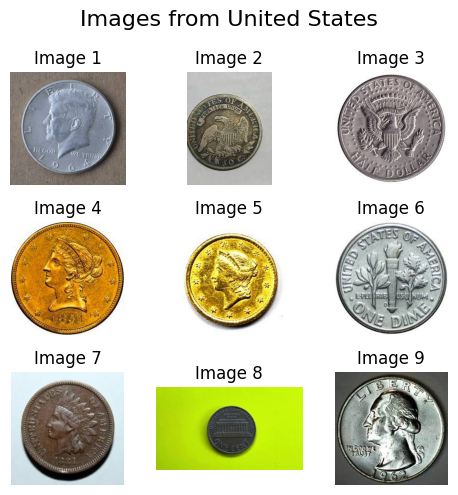

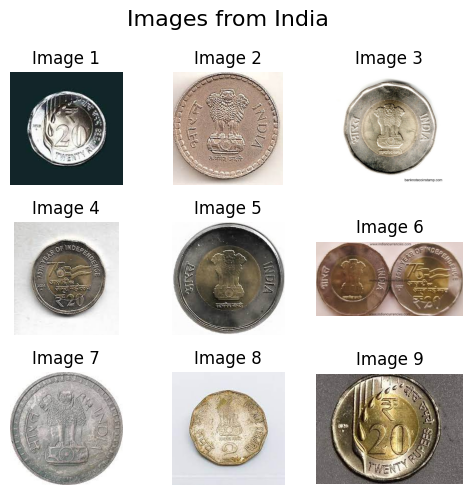

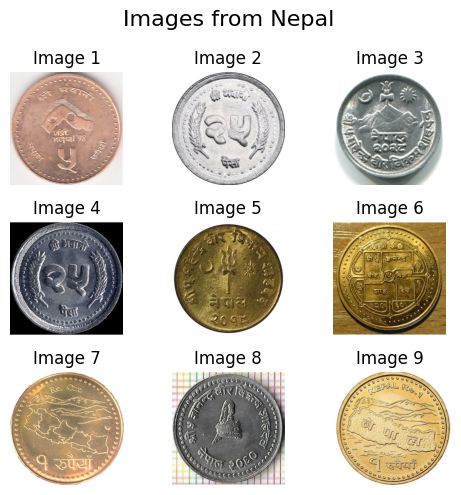

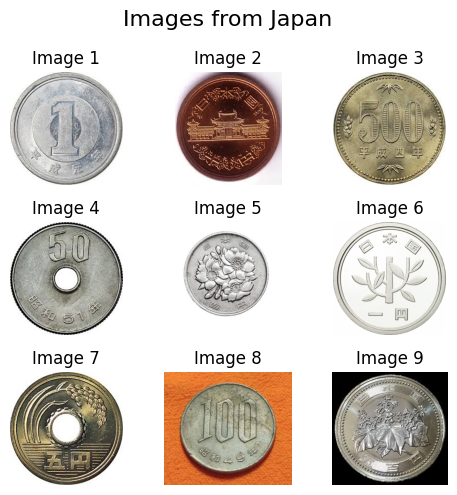

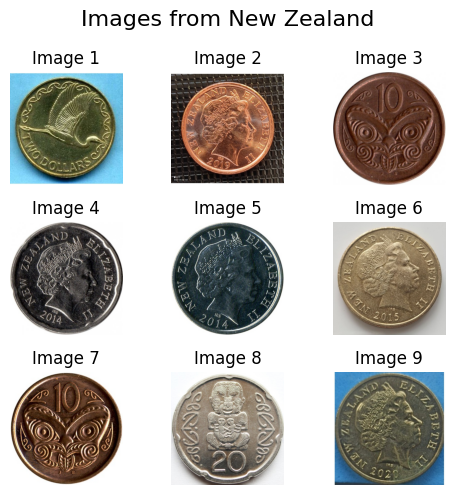

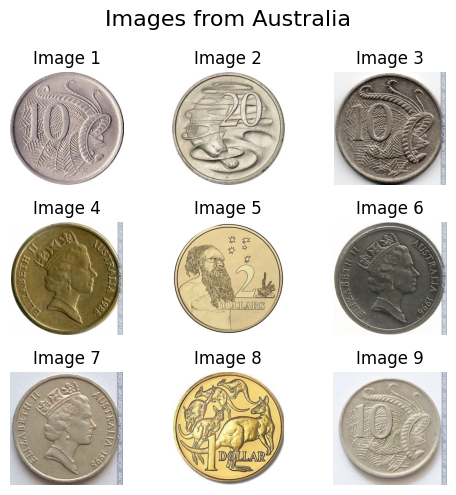

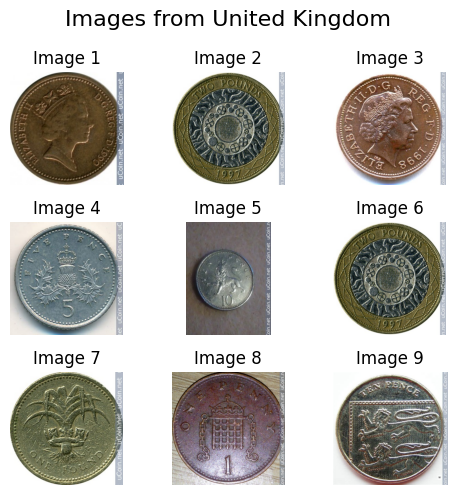

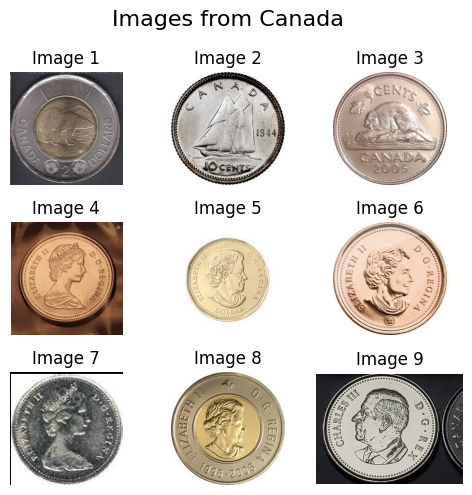

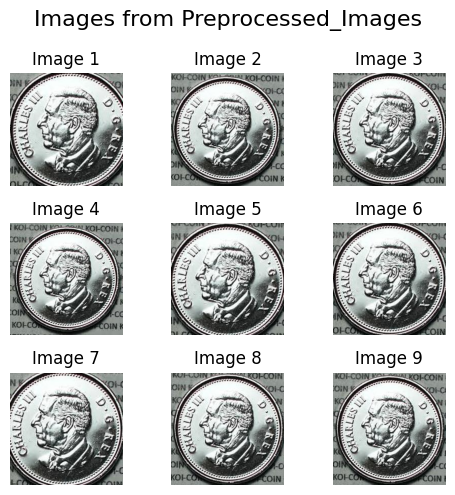

In [ ]:
#Prerequisite for this cell: Right click on CoinImages in drive. Organize and then add short cut to My Drive
folder_path = "/content/drive/My Drive/CoinImages"
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

country_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

# Loop through each country folder
for country in country_folders:
    country_path = os.path.join(folder_path, country)

    # Collect all images from this country's subfolders
    image_files = []
    for root, _, files in os.walk(country_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))

    # If no images found, skip this country
    if len(image_files) == 0:
        print(f"No images found for {country}")
        continue

    # Select 9 random images (or fewer if less than 9 exist)
    random_images = random.sample(image_files, min(9, len(image_files)))

    # Display images in a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    fig.suptitle(f"Images from {country}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(random_images):
            img_path = random_images[i]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"Image {i+1}")
        ax.axis("off")  # Hide axes if no image

    plt.tight_layout()
    plt.show()

# **Data Preprocessing** DRAFT VERSION WILL EDIT LATER

This step will include image preprocessing methodoligies so as to increase the quality of the dataset before the training process. Techniques such as Image size standardization, normalization and augmentation will be used to:
1. Create additional images to bring the image per class count to 50.
2. Bring about variation and diversity in the original dataset, without permanently altering the dataset itself.

Reasons for choosing the steps:
1. Greyscale conversion transforms a three-channel image into a single channel, which helps reduce computational complexity, lower memory usage, and enhance processing speed.
2. Median blur smoothens out the noise from the coin images, while preserving the edge, which will make it easier to apply Hough Circle detection.
3. Hough Circle detection helps to identify and isolate circular regions of interest, such as coins, from the background by detecting prominent circular shapes within an image.

In [ ]:
# def image_preprocessor(img_path, img_size = (224,224)):
#   """
#   The function will load a coin image, detect the coin via Hough Circle detection,
#   crop to the coin area, and resize to the desired output size.
#   """
#   image = cv2.imread(img_path)
#   if image is None:
#     return None

#   # Greyscale Conversion
#   gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#   # Median
#   median_img = cv2.medianBlur(gray_img, 5)

#   # Hough Circle Detectoin
#   circles = cv2.HoughCircles(
#       median_img,
#       cv2.HOUGH_GRADIENT,
#         dp=1.2,
#         minDist=100,
#         param1=50,
#         param2=30,
#         minRadius=50,
#         maxRadius=300
#     )

#   # Using the first circle found if other circles are detected
#   if circles is not None:
#     circles = np.around(circles[0, :]).astype("int")
#     x, y, r = circles[0]
#     x1 = max(x - r, 0)
#     y1 = max(y - r, 0)
#     x2 = min(x + r, img.shape[1])
#     y2 = min(y + r, img.shape[0])
#     coin_image = img[y1:y2, x1:x2]

#     # If no circle is detected, use the original image
#   else:
#     print("No coin detected in ", img_path)
#     coin_image = image

#   # Conversion from BGR to RGB
#   coin_image = cv2.cvtColor(coin_image, cv2.COLOR_BGR2RGB)
#   coin_image = Image.fromarray(coin_image)

#   # Resizing to the image to a standard size of 224x224
#   final_image = coin_image.resize(img_size)
#   return final_image

In [ ]:
def save_preprocessed_image(input_path, output_path, output_size=(224, 224)):
    """
    Preprocesses the images and then saves them to the specified path
    """
    # coin_img = image_preprocessor(input_path, output_size)
    coin_img = preprocess_coin_image(input_path, output_size)
    if coin_img is not None:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        coin_img.save(output_path)
        print("Saved preprocessed image to", output_path)
    else:
        print("Failed to preprocess", input_path)


In [ ]:
# --- Preprocessing (coin detection & crop) function ---
def preprocess_coin_image(image_path, output_size=(224, 224)):
    """
    The function will load a coin image, detect the coin via Hough Circle detection,
    crop to the coin area, and resize to the desired output size.
    """
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load image:", image_path)
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.medianBlur(gray, 5)

    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=100,
        param1=50,
        param2=30,
        minRadius=50,
        maxRadius=300
    )

    if circles is not None:
        # Convert to signed ints to avoid underflow issues.
        circles = np.around(circles[0, :]).astype("int")
        x, y, r = circles[0]
        x1 = max(x - r, 0)
        y1 = max(y - r, 0)
        x2 = min(x + r, img.shape[1])
        y2 = min(y + r, img.shape[0])
        coin_img = img[y1:y2, x1:x2]
    else:
        coin_img = img

    coin_img = cv2.cvtColor(coin_img, cv2.COLOR_BGR2RGB)
    coin_img = Image.fromarray(coin_img)
    coin_img = coin_img.resize(output_size, Image.Resampling.LANCZOS)
    return coin_img

# --- Random augmentation functions ---
def random_rotate(image, angle_range=(-10, 10)):
    angle = random.uniform(*angle_range)
    return image.rotate(angle)

def random_flip(image):
    # Flip horizontally with 50% chance
    if random.choice([True, False]):
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

def random_brightness(image, factor_range=(0.8, 1.2)):
    factor = random.uniform(*factor_range)
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

def random_color(image, factor_range=(0.8, 1.2)):
    factor = random.uniform(*factor_range)
    enhancer = ImageEnhance.Color(image)
    return enhancer.enhance(factor)

def random_contrast(image, factor_range=(0.8, 1.2)):
    factor = random.uniform(*factor_range)
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)

# Wrapper that randomly chooses one augmentation to apply
def apply_random_augmentation(image):
    # List of augmentation functions; include an identity lambda if you want to sometimes apply no change.
    augmentations = [lambda img: img, random_rotate, random_flip, random_brightness, random_color, random_contrast]
    augmentation_func = random.choice(augmentations)
    return augmentation_func(image)

# --- Process and save a randomly augmented image ---
def process_and_save_image(input_path, output_path):
    preprocessed = preprocess_coin_image(input_path)
    if preprocessed is None:
        return
    augmented = apply_random_augmentation(preprocessed)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    augmented.save(output_path)
    print("Saved preprocessed image to", output_path)


In [ ]:

def ensure_50_images_per_class(class_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    image_paths = [
        os.path.join(class_folder, f)
        for f in os.listdir(class_folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    current_count = len(image_paths)
    augment_needed = max(0, 50 - current_count)

    # First copy original images to the output folder after preprocessing
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        output_path = os.path.join(output_folder, filename)
        process_and_save_image(img_path, output_path)

    # Generate augmented images if needed
    if augment_needed > 0:
        print(f"Generating {augment_needed} augmented images for {class_folder}")
        for i in range(augment_needed):
            source_img_path = random.choice(image_paths)
            preprocessed_image = preprocess_coin_image(source_img_path)
            if preprocessed_image is None:
                continue  # skip if preprocessing fails
            augmented_image = apply_random_augmentation(preprocessed_image)

            # Save augmented images with distinct naming
            aug_filename = f"aug_{i+1}_{os.path.basename(source_img_path)}"
            output_path = os.path.join(output_folder, aug_filename)
            augmented_image.save(output_path)

# --- Main loop ---
for country in os.listdir(base_folder):
    country_path = os.path.join(base_folder, country)
    if not os.path.isdir(country_path):
        continue

    # Loop through denomination folders
    for denomination in os.listdir(country_path):
        class_folder = os.path.join(country_path, denomination)
        if not os.path.isdir(class_folder):
            continue

        # Output path mirrors original structure
        output_folder = os.path.join(output_base_folder, country, denomination)

        ensure_50_images_per_class(class_folder, output_folder)

print("Dynamic augmentation to reach 50 images per class completed.")


Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/1h.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/1t.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/2t.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/2h.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/3h.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/3t.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/4t.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/5t.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/

KeyboardInterrupt: 

In [ ]:
output_path = folder_path + "/Preprocessed_images"
os.makedirs(output_path, exist_ok=True)

In [ ]:
output_folder_path = "/content/drive/My Drive/CoinImages/Preprocessed_Images"

country_folders = [
    f for f in os.listdir(folder_path)
    if os.path.isdir(os.path.join(folder_path, f))
]

for country in country_folders:
    country_path = os.path.join(folder_path, country)

    # Process images inside each country's subfolders
    for root, _, files in os.walk(country_path):
        for file in tqdm(files, desc=f"Processing {country}"):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                input_path = os.path.join(root, file)

                # Mirror directory structure for output
                relative_path = os.path.relpath(input_path, folder_path)
                output_path = os.path.join(output_folder_path, relative_path)

                # Save preprocessed image
                save_preprocessed_image(input_path, output_path)

print("Dataset preprocessing completed.")


Processing United States:   3%|▎         | 1/32 [00:00<00:14,  2.11it/s]

Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/1h.jpeg


Processing United States:   6%|▋         | 2/32 [00:00<00:12,  2.32it/s]

Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/1t.jpeg


Processing United States:   9%|▉         | 3/32 [00:01<00:12,  2.41it/s]

Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/2t.jpeg


Processing United States:  16%|█▌        | 5/32 [00:01<00:07,  3.76it/s]

Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/2h.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/3h.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/3t.jpeg


Processing United States:  28%|██▊       | 9/32 [00:01<00:03,  7.42it/s]

Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/4t.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/5t.jpeg
Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/6t.jpeg


Processing United States:  31%|███▏      | 10/32 [00:02<00:03,  5.85it/s]

Saved preprocessed image to /content/drive/My Drive/CoinImages/Preprocessed_Images/United States/USD 5¢/7t.jpeg


In [30]:
import os
import csv
from google.colab import drive
from PIL import Image

drive.mount('/content/drive')  # Mount Google Drive

# Set the base directory where images are stored in Google Drive
BASE_DIR = '/content/drive/My Drive/CoinImages'  # Change this to your folder
CSV_FILE = 'image_data.csv'

# Function to generate Google Drive shareable links
def get_drive_link(file_path):
    file_id = file_path.split('drive/My Drive/')[-1]
    return f'https://drive.google.com/uc?id={file_id}'

# Collect image data
data = []
allowed=['New Zealand','Nepal','Japan']
for country_folder in os.listdir(BASE_DIR):
  if country_folder in allowed:
    country_path = os.path.join(BASE_DIR, country_folder)

    if os.path.isdir(country_path):
        for denomination_folder in os.listdir(country_path):
            denomination_path = os.path.join(country_path, denomination_folder)
            if os.path.isdir(denomination_path):
                for image_file in os.listdir(denomination_path):
                    image_path = os.path.join(denomination_path, image_file)
                    try:
                        with Image.open(image_path) as img:
                            width, height = img.size
                            print(width,height)
                        drive_link = get_drive_link(image_file)
                        data.append([drive_link, image_file, f'{denomination_folder}', width, height])
                    except Exception as e:
                        print(f"Error processing {image_file}: {e}")

# Write to CSV
with open(CSV_FILE, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['URL', 'image name', 'class', 'width', 'height'])
    writer.writerows(data)

print(f'CSV file "{CSV_FILE}" created successfully.')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
985 1028
1013 1032
1083 893
971 952
839 747
925 812
823 703
797 702
601 592
570 567
508 483
503 487
766 753
757 752
400 400
477 477
700 700
700 700
500 500
500 500
600 600
600 600
662 662
700 700
600 600
600 600
593 593
593 593
500 500
500 500
414 414
382 382
700 700
700 700
225 225
223 226
225 224
1928 1888
221 228
672 657
224 224
225 225
400 400
225 225
225 225
225 225
753 737
500 500
225 225
700 700
505 505
500 500
500 500
500 500
540 540
540 540
474 474
468 468
500 500
500 500
700 700
700 700
251 251
251 251
500 500
500 500
500 500
500 500
319 319
322 322
600 600
600 600
475 475
481 481
497 497
496 496
600 600
600 600
400 400
403 403
600 600
600 600
225 225
225 225
300 400
227 222
227 222
226 223
194 259
227 222
228 221
194 259
225 225
262 192
1200 1163
222 227
225 225
224 225
765 747
1200 958
1080 935
1645 1316
1037 956
1074 1178
1027 915
917 955
878 909

In [31]:
df = pd.read_csv('image_data.csv')
df

,URL,image name,class,width,height
0,https://drive.google.com/uc?id=1h.jpg,1h.jpg,2 Nepali Rupee,985,1028
1,https://drive.google.com/uc?id=1t.jpg,1t.jpg,2 Nepali Rupee,1013,1032
2,https://drive.google.com/uc?id=2h.jpg,2h.jpg,2 Nepali Rupee,1083,893
3,https://drive.google.com/uc?id=2t.jpg,2t.jpg,2 Nepali Rupee,971,952
4,https://drive.google.com/uc?id=3t.jpg,3t.jpg,2 Nepali Rupee,839,747
...,...,...,...,...,...
792,https://drive.google.com/uc?id=21h.jpeg,21h.jpeg,NZ 50 c,222,227
793,https://drive.google.com/uc?id=22h.jpeg,22h.jpeg,NZ 50 c,225,225
794,https://drive.google.com/uc?id=23h.jpg,23h.jpg,NZ 50 c,1024,1024
795,https://drive.google.com/uc?id=24h.jpeg,24h.jpeg,NZ 50 c,225,225


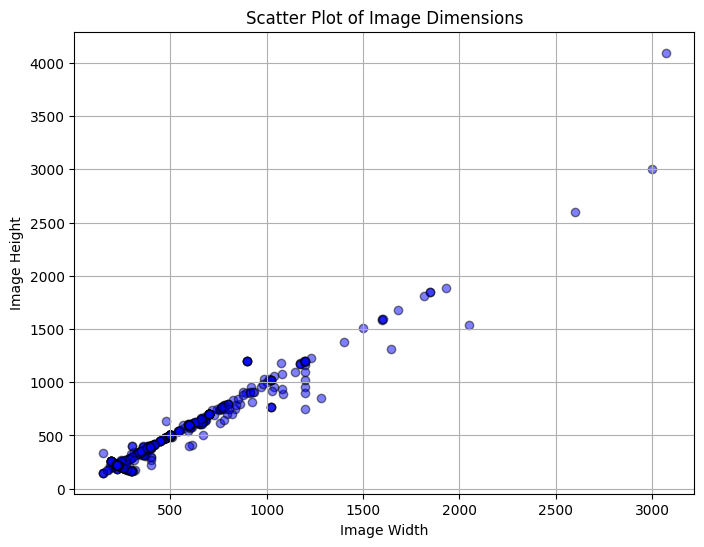

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('image_data.csv')

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['width'], df['height'], alpha=0.5, c='blue', edgecolors='black')

# Labels and title
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title('Scatter Plot of Image Dimensions')
plt.grid(True)

# Show the plot
plt.show()

In [35]:
median_width = df['width'].median()
median_height = df['height'].median()

print(f"Median Width: {median_width}")
print(f"Median Height: {median_height}")

Median Width: 384.0
Median Height: 384.0


In [38]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('image_data.csv')

# Count images where width = 224 and height = 224
count_224 = df[(df['width'] == 384) & (df['height'] == 384)].shape[0]

print(f"Number of images with width and height both as 224: {count_224}")

Number of images with width and height both as 224: 0
